In [13]:
from pandas import read_csv
#Load data set
look_back = 15
split = 735-200
series_influ_A_df = read_csv('../temp_data/influA_vietnam_last_10_days.csv', index_col=0, engine='python')
series_influ_A_df = series_influ_A_df.iloc[200:]
train_df = series_influ_A_df.iloc[0:split]
test_df = series_influ_A_df.iloc[split-look_back:]
# series_influ_A_df = series_influ_A_df["case"]

series_influ_A_df = series_influ_A_df.rename(columns= {"Influenza A - All types of surveillance": "case"})
series_influ_A_df = series_influ_A_df[["case", "temp", "tempmax", "dew","windspeed"]]

In [14]:
def exponential_moving_average(data, span):
    return data.ewm(span=span, adjust=False).mean()

In [15]:
series_influ_A_df = series_influ_A_df.dropna()
span = 52  # Bạn có thể điều chỉnh độ dài span tùy ý
series_influ_A_df['case'] = exponential_moving_average(series_influ_A_df['case'], span)
series_influ_A_df = series_influ_A_df.astype('float32')
series_influ_A_df = series_influ_A_df.values
# normalize the dataset
from sklearn.preprocessing import MinMaxScaler, RobustScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(series_influ_A_df)
# scaler = RobustScaler()
# dataset = scaler.fit_transform(series_influ_A_df)
# Create Training and Test

train = dataset[:split, :]
test = dataset[split-look_back:, :]

import numpy as np
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [16]:
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN


model = Sequential([
    SimpleRNN(units=64, activation='relu', input_shape=(look_back,5)),
     Dense(units=32, activation='relu'),
      Dense(units=16, activation='relu'),
    Dense(units=5, activation='sigmoid' )
])

# # Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, validation_data=(testX, testY))

c:\Users\nghiemxuan\Desktop\nghiem\GR3\GR3\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
520/520 - 3s - 5ms/step - loss: 0.0326 - val_loss: 0.0181
Epoch 2/100
520/520 - 1s - 2ms/step - loss: 0.0164 - val_loss: 0.0141
Epoch 3/100
520/520 - 1s - 2ms/step - loss: 0.0113 - val_loss: 0.0130
Epoch 4/100
520/520 - 1s - 2ms/step - loss: 0.0102 - val_loss: 0.0111
Epoch 5/100
520/520 - 1s - 2ms/step - loss: 0.0094 - val_loss: 0.0108
Epoch 6/100
520/520 - 1s - 2ms/step - loss: 0.0091 - val_loss: 0.0108
Epoch 7/100
520/520 - 1s - 2ms/step - loss: 0.0088 - val_loss: 0.0106
Epoch 8/100
520/520 - 1s - 2ms/step - loss: 0.0085 - val_loss: 0.0113
Epoch 9/100
520/520 - 1s - 2ms/step - loss: 0.0084 - val_loss: 0.0121
Epoch 10/100
520/520 - 1s - 2ms/step - loss: 0.0084 - val_loss: 0.0106
Epoch 11/100
520/520 - 1s - 2ms/step - loss: 0.0082 - val_loss: 0.0102
Epoch 12/100
520/520 - 1s - 2ms/step - loss: 0.0077 - val_loss: 0.0097
Epoch 13/100
520/520 - 1s - 2ms/step - loss: 0.0079 - val_loss: 0.0106
Epoch 14/100
520/520 - 1s - 2ms/step - loss: 0.0079 - val_loss: 0.0112
Epoch 15/100
52

In [24]:
from sklearn.metrics import mean_squared_error
# [[1,3]] :shape 1,2
def predict_one(X, model):
    X= np.array([X])
    predicted = model.predict(X, verbose=0)
    return predicted[0]


#X_start: [[1,3]]
def predict(X_start, num_weeks, model):
    result = []
    X=np.array([X_start])
    for i in range(num_weeks):
        predicted = predict_one(X[i], model)
        result.append(predicted)
        X_continue = np.vstack((X[-1][1:], predicted.reshape(1,5)))
        X = np.append(X, [X_continue], axis=0)
    import json
    # with open('./X.json', 'w') as f:
    #     json.dump(X.tolist(), f)
    return result
    
# make predictions
# testPredict = model.predict(testX)
testPredict = predict(testX[0], len(test)-look_back, model)
# invert predictions
testPredict = scaler.inverse_transform(testPredict)
testY_ = scaler.inverse_transform(testY)
# calculate root mean squared error
testScore = np.sqrt(mean_squared_error(testY_, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 4.41 RMSE


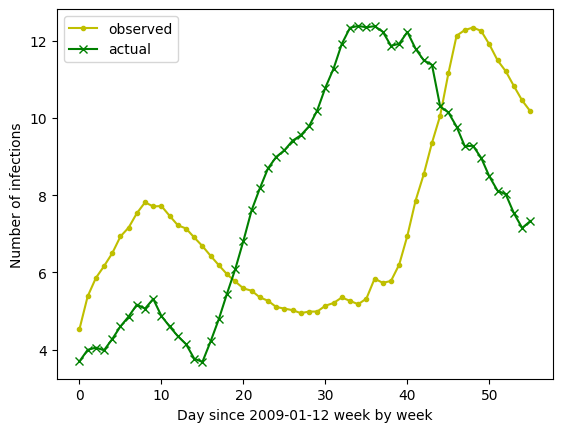

In [25]:

import matplotlib.pyplot as plt
# (x,3)
testPredictPlot = np.empty([testX.shape[0]])
testPredictPlot[:] = np.nan
testPredictPlot[:] = testPredict[:,0].reshape(-1)
testPlot = np.empty([testX.shape[0]])
testPlot[:] = np.nan
testPlot[:] = scaler.inverse_transform(test[look_back:])[:,0].reshape(-1)
# plt.plot(scaler.inverse_transform(train)[:,0].reshape(-1), label="observed")
plt.plot(testPlot, "-y", label="actual", marker= '.')
plt.plot(testPredictPlot, color = 'green', label="forecast", marker='x')
plt.xlabel("Day since 2009-01-12 week by week")
plt.ylabel("Number of infections")
plt.legend(["observed", "actual", "forecast"])
plt.show()

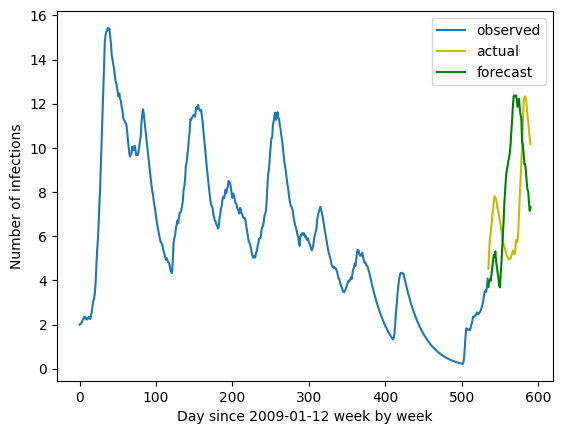

In [20]:

import matplotlib.pyplot as plt
# (x,3)
testPredictPlot = np.empty([dataset.shape[0]])
testPredictPlot[:] = np.nan
testPredictPlot[len(train):len(dataset)] = testPredict[:,0].reshape(-1)
testPlot = np.empty([dataset.shape[0]])
testPlot[:] = np.nan
testPlot[len(train):len(dataset)] = scaler.inverse_transform(test[look_back:])[:,0].reshape(-1)
plt.plot(scaler.inverse_transform(train)[:,0].reshape(-1), label="observed")
plt.plot(testPlot, "-y", label="actual")
plt.plot(testPredictPlot, color = 'green', label="forecast")
plt.xlabel("Day since 2009-01-12 week by week")
plt.ylabel("Number of infections")
plt.legend(["observed", "actual", "forecast"])
plt.show()

In [23]:
model.save("../model/RNN_15_sigmoid.keras")

import tensorflow as tf
# model = tf.keras.models.load_model("../model/RNN_sigmoid.keras")